

########################################## Train dataset ##############################################################


colza_SAR_vv_train.shape (507, 21)


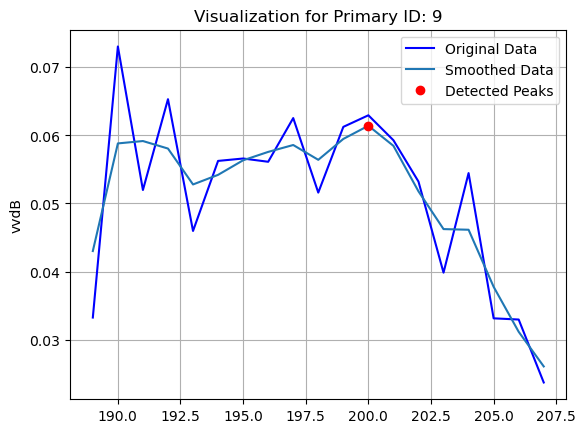

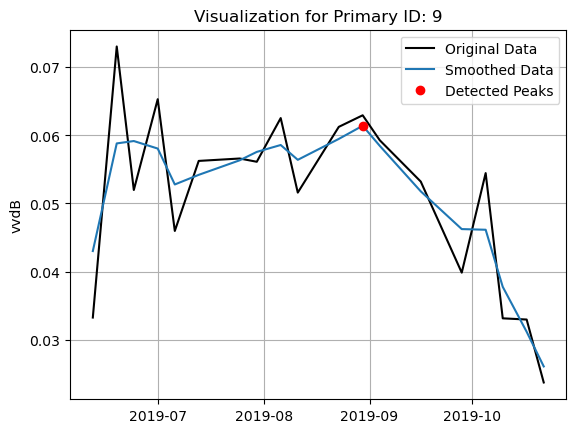

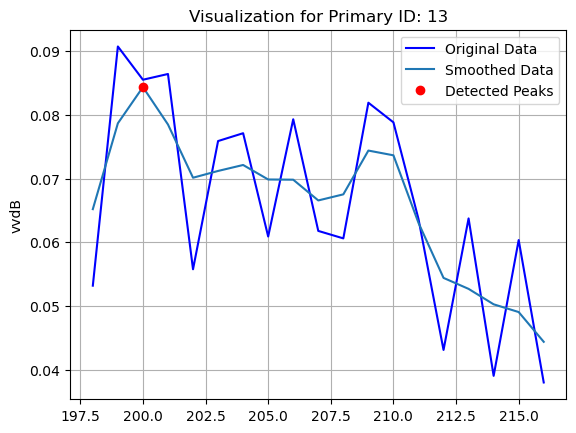

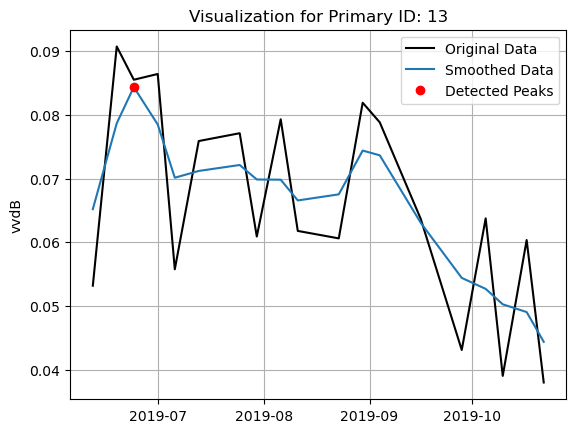

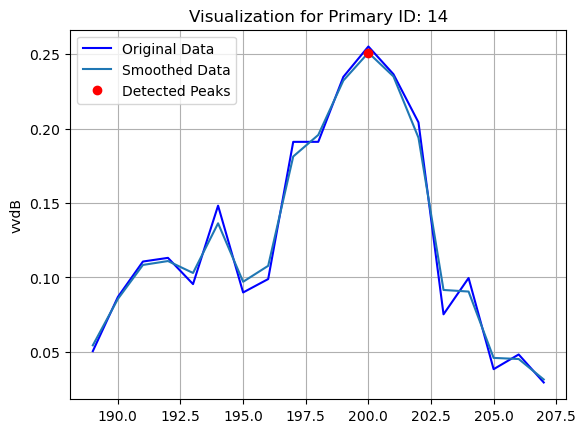

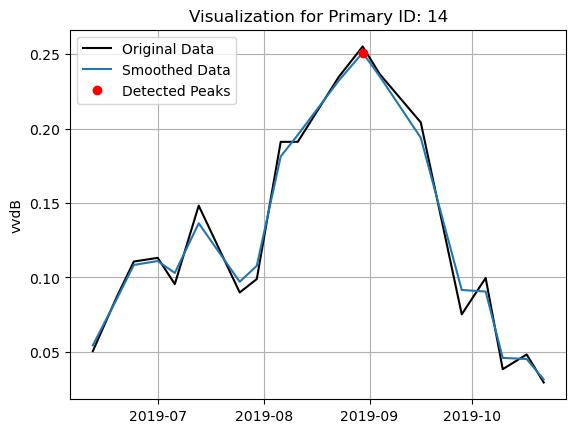

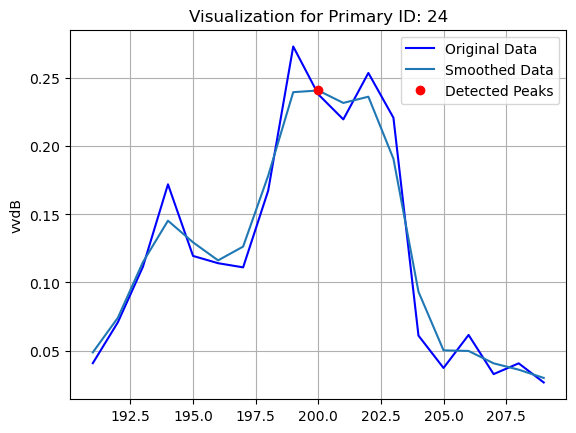

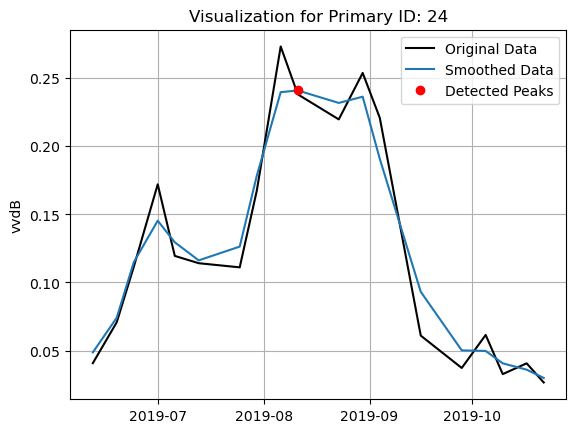

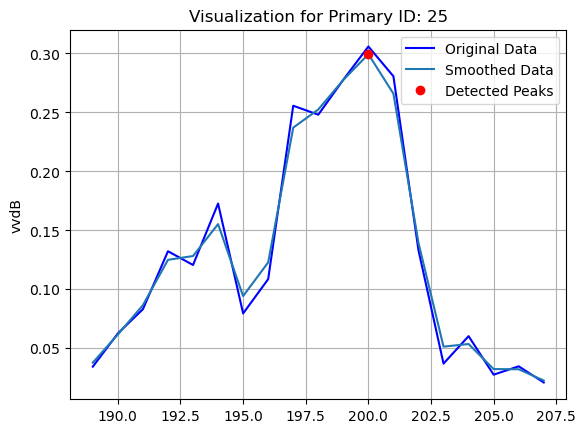

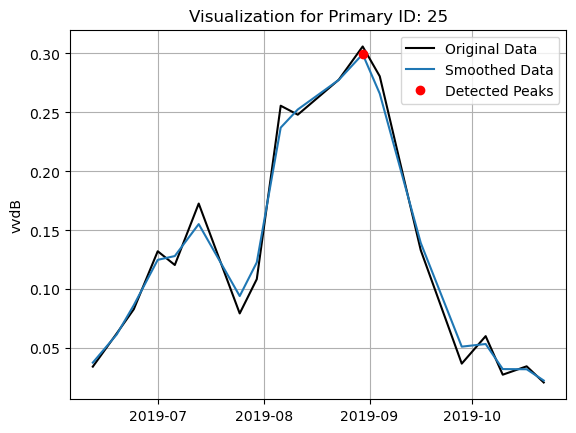

Mean  n_timestamps_before_peak_vv_train: 10


########################################## Test dataset ##############################################################
SAR_vv_test.shape (3471, 21)


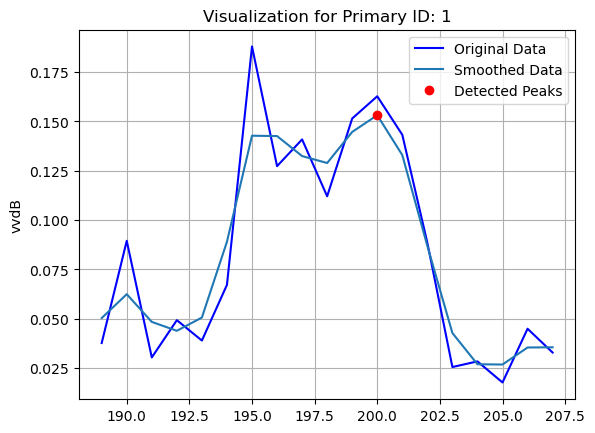

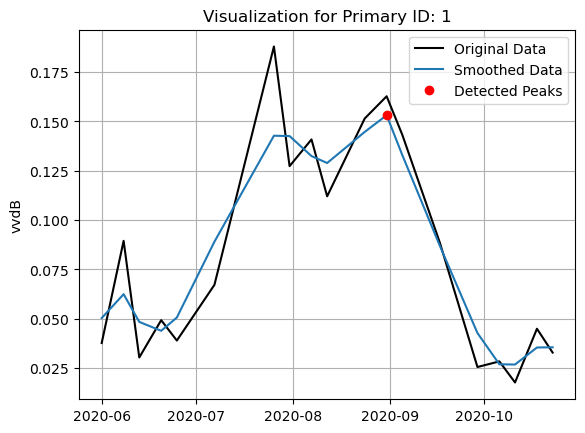

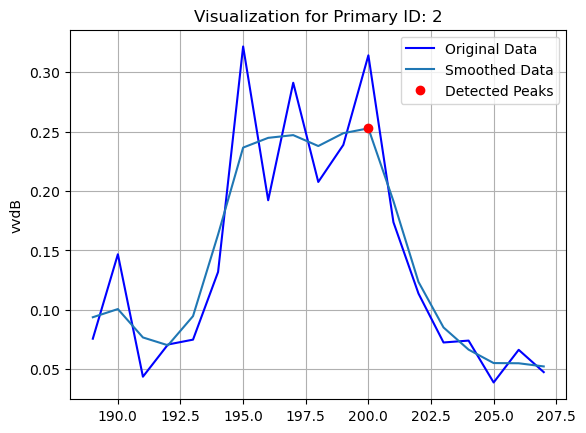

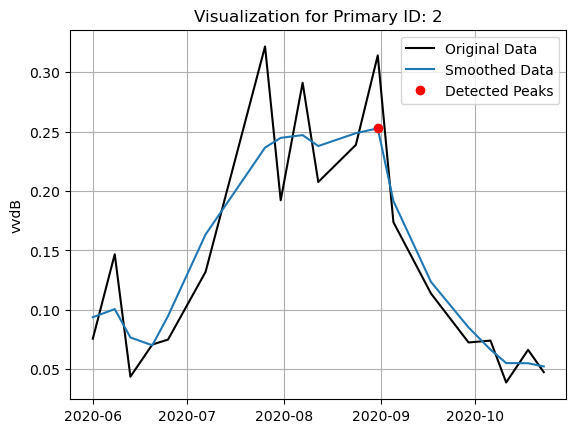

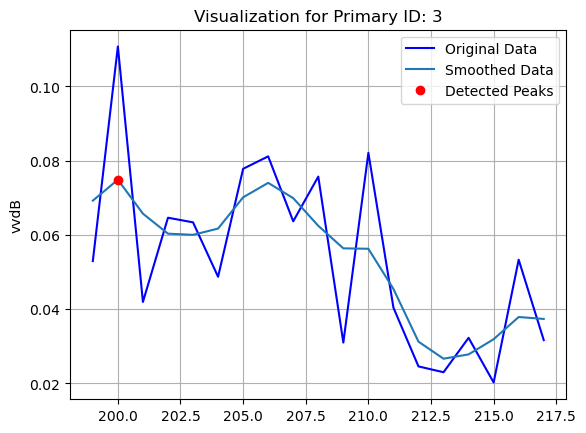

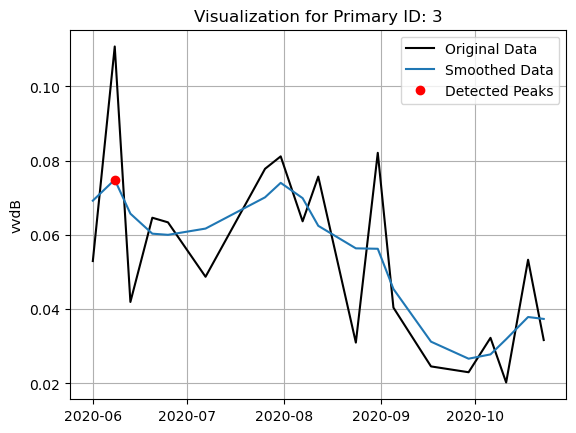

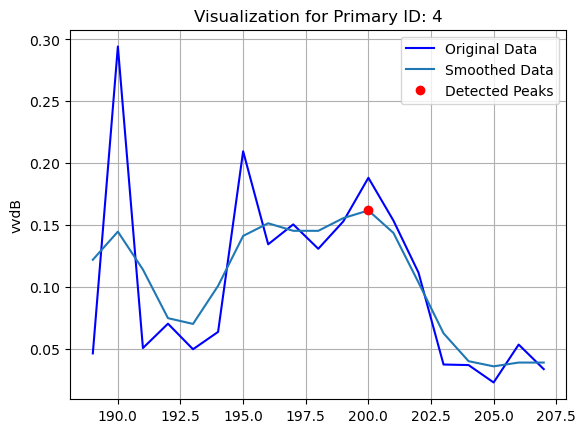

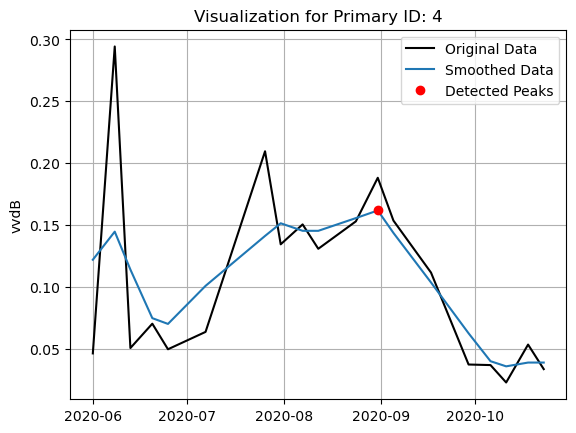

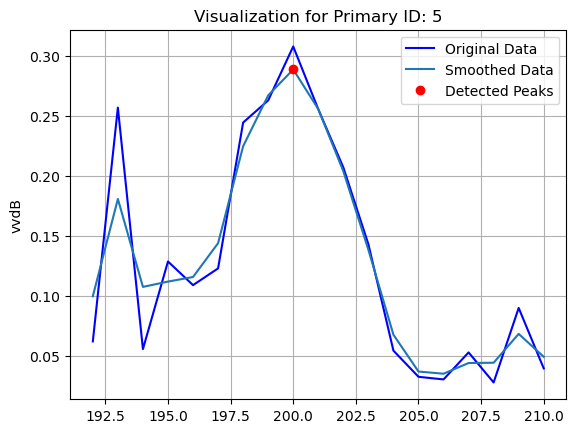

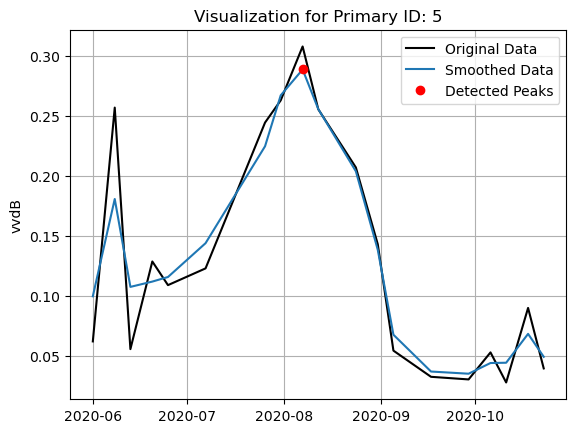

Mean n_timestamps_before_peak_vv_test: 7


########################################## Results ##############################################################


Mean 3  timestamps should be added to the begining of the test and remove from the end
Use Set_number= 10 in the next code for alignemnt


In [21]:
######### Created by Saeideh Maleki
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from datetime import datetime
import matplotlib.dates as mdates
def to_dB(x):
    return 10 * np.log10(x)


##Part 1: Code to Identify the Dataset Requiring Additional Timesteps and Calculate the Number of Timesteps to Add

########################################################### train dataset ###################################################################################
print("\n")
print ('########################################## Train dataset ##############################################################')
print("\n")

def smooth_and_plot_train(df, pol_label, year_train, dates_SAR_train):
    """
    Function to smooth data, detect peaks, and plot the results.
    :param df: DataFrame containing the data to process.
    :param pol_label: Label for the polarization .
    :param year: Year of the data for range filtering.
    :param dates_SAR: DataFrame of dates corresponding to the data rows.
    :return: DataFrames with peak information and smoothed data.
    """
    # Initialize a list to store dictionaries with peak information
    peak_data = []
    # Initialize a list to store doys_arr for each row
    doys_adjusted_list = []
    vv_smoothgauss_list = []
    y_multi_train_filtered = []  # To store y_multi_train corresponding to smoothed rows

    fig_count = 0
    # Smooth and plot data for each row
    for i in range(len(df)):
        data = df.iloc[i, :-2].values  # Exclude the last two columns (including 'y_multi_train' and 'primary_id')

        # Convert data to float and handle missing values (NaN)
        data = data.astype(float)

        # Remove NaN values if any
        data = np.nan_to_num(data)
        # Use index as day of year
        doys_arr = np.arange(len(data))  

        nb = 4
        f = 0
        smoothed = []  # Initialize an empty list to store the smoothed values
        while nb > 3:
            f += 0.01
            data_smoothgauss = ndimage.filters.gaussian_filter(data, f)

            peak_pos, peak_amp = [], []
            bottom_pos, bottom_amp = [], []
            for k in range(1, len(data_smoothgauss) - 1):
                if data_smoothgauss[k - 1] < data_smoothgauss[k] > data_smoothgauss[k + 1]:
                    peak_pos.append(doys_arr[k])
                    peak_amp.append(data_smoothgauss[k])

            for l in range(1, len(data_smoothgauss) - 1):
                if data_smoothgauss[l - 1] > data_smoothgauss[l] < data_smoothgauss[l + 1]:
                    bottom_pos.append(doys_arr[l])
                    bottom_amp.append(data_smoothgauss[l])

            nb = len(peak_pos)

        # Find the highest peak only between April 1st and July 1st for France
        ## Find the highest peak only between June 1st and November 1st for North America

        peaks_within_range = []
        for j in range(len(peak_pos)):
            if pd.Timestamp(year=year_train, month=6, day=1) <= dates_SAR_train.iloc[peak_pos[j]]['Date'] < pd.Timestamp(year=year_train, month=11, day=1):
                peaks_within_range.append(j)

        if len(peaks_within_range) > 0:
            highest_peak_index = np.argmax([peak_amp[j] for j in peaks_within_range])
            highest_peak = peak_amp[peaks_within_range[highest_peak_index]]
            highest_date = dates_SAR_train.iloc[peak_pos[peaks_within_range[highest_peak_index]]]['Date']
            highest_doy = peak_pos[peaks_within_range[highest_peak_index]]

            # Set 100 as the DOY of the highest peak
            doys_adjusted = doys_arr - (highest_doy - 100)

            # Calculate the differences and modify the DOY values
            differences = doys_adjusted - doys_arr
            for idx, difference in enumerate(differences):
                if difference > 0:
                    doys_adjusted[idx] += 100
                elif difference < 0:
                    doys_adjusted[idx] -= 100
                    
        # Extract the first adjusted DOY from each row
        first_doys_adjusted = [adjusted_row[0] for adjusted_row in doys_adjusted_list]
        # Store the last adjusted DOY
        last_adjusted_doy = doys_adjusted[-1]

        # Adjust DOY values and store in doys_adjusted_list
        vv_smoothgauss_list.append(data_smoothgauss)
        y_multi_train_filtered.extend([y_multi_train[i]] * len(peak_amp))
        doys_adjusted_list.append(doys_adjusted) 
        # Get the primary_id for the current row
        current_primary_id = df['primary_id'].iloc[i] 
        # Store peak information along with the corresponding primary_id in a dictionary
        peak_info = {
            'Peak Value': highest_peak,
            'ID': i,
            'Date': highest_date,
            'DOY': highest_doy,
            'First DOY Adjusted': doys_adjusted_list[i][0],  # Add the first adjusted DOY here           
            'Last DOY Adjusted': last_adjusted_doy,  # Add the last adjusted DOY here
            'y_multi_train': df['y_multi_train'].iloc[i],
            'primary_id': current_primary_id
        }

        # Append the dictionary to the peak_data list
        peak_data.append(peak_info)            

            ############################################## plot
        if fig_count < 10:  # Limit the number of plots to the first 10 rows with no detected peaks
                plt.figure(fig_count)
                plt.plot(doys_adjusted, data, color='blue', label='Original Data')
                plt.plot(doys_adjusted, data_smoothgauss, label='Smoothed Data')
                plt.plot(doys_adjusted[highest_doy], highest_peak, 'o', color='r', label='Detected Peaks')
                plt.title(f"Visualization for Primary ID: {current_primary_id}")  # Set the title with primary_id
                plt.ylabel(f"{pol_label}dB")
                plt.legend()
                plt.grid()
                plt.show()
                fig_count += 1
             
        if fig_count < 10:  # Limit the number of plots
                plt.figure(fig_count)
                plt.plot(dates_SAR_train, data, color='black', label='Original Data')
                plt.plot(dates_SAR_train, data_smoothgauss, label='Smoothed Data')
                plt.plot(highest_date, highest_peak, 'o', color='r', label='Detected Peaks')
                # Get the primary_id for the current row
                current_primary_id = df['primary_id'].iloc[i]
                plt.title(f"Visualization for Primary ID: {current_primary_id}")  # Set the title with primary_id
                plt.ylabel(f"{pol_label}dB")
                # Format x-axis for cleaner date labels
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Year-Month format
                plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Tick every month
                plt.legend()
                plt.grid()
                plt.show()
                fig_count += 1


    # Create a DataFrame from the peak_data list
    peak_df_train = pd.DataFrame(peak_data)

    # Convert vv_smoothgauss_list to a DataFrame
    vv_smoothgauss_df_train = pd.DataFrame(vv_smoothgauss_list)
    return peak_df_train, vv_smoothgauss_df_train

# Load the numpy data
year_train=2019
dataset_train = np.load(
        f'F:/back/back2411/Colza_DB2/phase2n/One_year/W5/CA_US/CA2019_US2020/Colza_data_C_W5_2019_matched.npz', allow_pickle=True)
X_SAR_train, y_multi_train = dataset_train["X_SAR"], dataset_train["y"]
id_parcels_train, dates_SAR_train = dataset_train["id_parcels"], dataset_train["dates_SAR"]

# Convert dates_SAR_train to DataFrame
dates_SAR_train = pd.DataFrame(dates_SAR_train, columns=['Date'])

# Create vv_df from X_SAR_train[:, :, 0] ### vv is the first feature. 
#Since the number of vv and vh is equal we do the calculation before alignement using one of them

vv_df_train = pd.DataFrame(X_SAR_train[:, :, 0])
#vv_df = to_dB(vv_df)
vv_df_train['primary_id'] = id_parcels_train  # Add a new column "primary_id" to store the original IDs
vv_df_train['y_multi_train'] = y_multi_train  # Add a new column "y_multi_train" to store y_multi_train
colza_SAR_vv_train = vv_df_train[y_multi_train == "CZH"] 
print('colza_SAR_vv_train.shape', colza_SAR_vv_train.shape)
# Call the function for 'vv'
peak_df_vv_train, vv_smoothgauss_df_vv_train = smooth_and_plot_train(colza_SAR_vv_train, 'vv',year_train,dates_SAR_train)

########################################

mean_first_doy_adjusted_vv_train = peak_df_vv_train['First DOY Adjusted'].mean()
mean_n_timestamps_before_peak_vv_train = 200 - mean_first_doy_adjusted_vv_train
print("Mean  n_timestamps_before_peak_vv_train:", round(mean_n_timestamps_before_peak_vv_train))


################################################################################################################################
print("\n")
print ('########################################## Test dataset ##############################################################')
########################################################### test dataset ###################################################################################


def smooth_and_plot_test (df, pol_label,year_test,dates_SAR_test):
    # Initialize a list to store dictionaries with peak information
    peak_data = []
    # Initialize a list to store doys_arr for each row
    doys_adjusted_list = []
    vv_smoothgauss_list = []
    y_multi_test_filtered = []  # To store y_multi_test corresponding to smoothed rows

    fig_count = 0
    # Smooth and plot data for each row
    for i in range(len(df)):
        data = df.iloc[i, :-2].values  # Exclude the last two columns (including 'y_multi_test' and 'primary_id')

        # Convert data to float and handle missing values (NaN)
        data = data.astype(float)

        # Remove NaN values if any
        data = np.nan_to_num(data)

        doys_arr = np.arange(len(data))  # Use index as day of year

        nb = 4
        f = 0
        smoothed = []  # Initialize an empty list to store the smoothed values
        while nb > 3:
            f += 0.01
            data_smoothgauss = ndimage.filters.gaussian_filter(data, f)

            peak_pos, peak_amp = [], []
            bottom_pos, bottom_amp = [], []
            for k in range(1, len(data_smoothgauss) - 1):
                if data_smoothgauss[k - 1] < data_smoothgauss[k] > data_smoothgauss[k + 1]:
                    peak_pos.append(doys_arr[k])
                    peak_amp.append(data_smoothgauss[k])

            for l in range(1, len(data_smoothgauss) - 1):
                if data_smoothgauss[l - 1] > data_smoothgauss[l] < data_smoothgauss[l + 1]:
                    bottom_pos.append(doys_arr[l])
                    bottom_amp.append(data_smoothgauss[l])

            nb = len(peak_pos)

        # Find the highest peak only between April 1st and July 1st for France
        ## Find the highest peak only between June 1st and November 1st for North America

        peaks_within_range = []
        for j in range(len(peak_pos)):
            if pd.Timestamp(year=year_test, month=6, day=1) <= dates_SAR_test.iloc[peak_pos[j]]['Date'] < pd.Timestamp(year=year_test, month=11, day=1):
                peaks_within_range.append(j)

        if len(peaks_within_range) > 0:
            highest_peak_index = np.argmax([peak_amp[j] for j in peaks_within_range])
            highest_peak = peak_amp[peaks_within_range[highest_peak_index]]
            highest_date = dates_SAR_test.iloc[peak_pos[peaks_within_range[highest_peak_index]]]['Date']
            highest_doy = peak_pos[peaks_within_range[highest_peak_index]]

            # Set 200 as the DOY of the highest peak
            doys_adjusted = doys_arr - (highest_doy - 100)

            # Calculate the differences and modify the DOY values
            differences = doys_adjusted - doys_arr
            for idx, difference in enumerate(differences):
                if difference > 0:
                    doys_adjusted[idx] += 100
                elif difference < 0:
                    doys_adjusted[idx] -= 100
                    
        # Extract the first adjusted DOY from each row
        first_doys_adjusted = [adjusted_row[0] for adjusted_row in doys_adjusted_list]
        # Store the last adjusted DOY
        last_adjusted_doy = doys_adjusted[-1]

        # Adjust DOY values and store in doys_adjusted_list
        vv_smoothgauss_list.append(data_smoothgauss)
        y_multi_test_filtered.extend([y_multi_test[i]] * len(peak_amp))
        doys_adjusted_list.append(doys_adjusted) 
        # Get the primary_id for the current row
        current_primary_id = df['primary_id'].iloc[i] 
        # Store peak information along with the corresponding primary_id in a dictionary
        peak_info = {
            'Peak Value': highest_peak,
            'ID': i,
            'Date': highest_date,
            'DOY': highest_doy,
            'First DOY Adjusted': doys_adjusted_list[i][0],  # Add the first adjusted DOY here           
            'Last DOY Adjusted': last_adjusted_doy,  # Add the last adjusted DOY here
            'y_multi_test': df['y_multi_test'].iloc[i],
            'primary_id': current_primary_id
        }

        # Append the dictionary to the peak_data list
        peak_data.append(peak_info)            

            ############################################## plot for test dataset##########################################
            
        if fig_count < 10:  # Limit the number of plots to the first 10 rows with no detected peaks
                plt.figure(fig_count)
                plt.plot(doys_adjusted, data, color='blue', label='Original Data')
                plt.plot(doys_adjusted, data_smoothgauss, label='Smoothed Data')
                plt.plot(doys_adjusted[highest_doy], highest_peak, 'o', color='r', label='Detected Peaks')
                plt.title(f"Visualization for Primary ID: {current_primary_id}")  # Set the title with primary_id
                plt.ylabel(f"{pol_label}dB")
                plt.legend()
                plt.grid()
                plt.show()
                fig_count += 1
             
        if fig_count < 10:  # Limit the number of plots to the first 10 rows with no detected peaks
                plt.figure(fig_count)
                plt.plot(dates_SAR_test, data, color='black', label='Original Data')
                plt.plot(dates_SAR_test, data_smoothgauss, label='Smoothed Data')
                plt.plot(highest_date, highest_peak, 'o', color='r', label='Detected Peaks')
                # Get the primary_id for the current row
                current_primary_id = df['primary_id'].iloc[i]
                plt.title(f"Visualization for Primary ID: {current_primary_id}")  # Set the title with primary_id
                plt.ylabel(f"{pol_label}dB")
                plt.legend()
                plt.grid()
                plt.show()
                fig_count += 1


    # Create a DataFrame from the peak_data list
    peak_df_test = pd.DataFrame(peak_data)

    # Convert vv_smoothgauss_list to a DataFrame
    vv_smoothgauss_df_test = pd.DataFrame(vv_smoothgauss_list)
    return peak_df_test, vv_smoothgauss_df_test

# Load the numpy data
year_test=2020
dataset_test = np.load(
        f'F:/back/back2411/Colza_DB2/phase2n/One_year/W5/CA_US/CA2019_US2020/Colza_data_U_new_5_{year_test}_matched.npz', allow_pickle=True)
X_SAR_test, y_multi_test = dataset_test["X_SAR"], dataset_test["y"]
id_parcels_test, dates_SAR_test = dataset_test["id_parcels"], dataset_test["dates_SAR"]

# Convert dates_SAR_test to DataFrame
dates_SAR_test = pd.DataFrame(dates_SAR_test, columns=['Date'])

vv_df_test = pd.DataFrame(X_SAR_test[:, :, 0])
#vv_df = to_dB(vv_df)
vv_df_test['primary_id'] = id_parcels_test  # Add a new column "primary_id" to store the original IDs
vv_df_test['y_multi_test'] = y_multi_test  # Add a new column "y_multi_test" to store y_multi_test
SAR_vv_test = vv_df_test
print('SAR_vv_test.shape', SAR_vv_test.shape)

# Call the function for 'vv'
peak_df_vv_test, vv_smoothgauss_df_vv_test = smooth_and_plot_test(SAR_vv_test, 'vv',year_test,dates_SAR_test)

########################################
mean_first_doy_adjusted_vv_test = peak_df_vv_test['First DOY Adjusted'].mean()
mean_n_timestamps_before_peak_vv_test = 200 - mean_first_doy_adjusted_vv_test
print("Mean n_timestamps_before_peak_vv_test:", round(mean_n_timestamps_before_peak_vv_test))


################################################################################################################################
print("\n")
print ('########################################## Results ##############################################################')
########################################################### test dataset ###################################################################################
print("\n")
   

### To determine the timesamps should be added to which dataset and estimate mean number of timestemps to be added. 
 
if mean_n_timestamps_before_peak_vv_test<mean_n_timestamps_before_peak_vv_train:
    move = mean_n_timestamps_before_peak_vv_train - mean_n_timestamps_before_peak_vv_test  
    print (f'Mean {round(move)}  timestamps should be added to the begining of the test and remove from the end')
    print (f'Use Set_number= {round(mean_n_timestamps_before_peak_vv_train)} in the next code for alignemnt')#The number of timestamps before highest peak of each plot will be set to this number. 
else:
    move = mean_n_timestamps_before_peak_vv_test - mean_n_timestamps_before_peak_vv_train   
    print (f'Mean {round(move)}  timestamps should be added to the begining of the train and remove from the end')
    print (f'Use Set_number= {round(mean_n_timestamps_before_peak_vv_test)} in the second script _Step2_Peak_Alignement_ for alignemnt')#The number of timestemps before highest peak of each plot will be set to this number.





